In [1]:
import pandas as pd
import nltk
%matplotlib inline
traindf = pd.read_csv('../input/train.csv')
traindf.head()
authorsdupl=traindf['author'].to_list()
authors=set(authorsdupl)
# print(authors)

Creating a dictionary of author : text from the train corpus

In [2]:
dictionaryauthors={}
for x in authors:
    dictionaryauthors[x]=""

text=traindf['text'].to_list()

for i in range(len(text)):
    
    dictionaryauthors[authorsdupl[i]]+=text[i]



In [ ]:
# print(dictionaryauthors['HPL'])

    
    

### First Stylometric Test: Mendenhall’s Characteristic Curves of Composition

This is basically a plot of the frequencies of words of different lengths. This is one of the most basic tests of authorship and has proven to be extremely useful in a number of stylometric ventures in the past.

1. Tokenise all the words in each author's texts and store them in another dictionary author: tokens
2. create a list of lengths of each token
3. get a frequency distribution object for the list
4. plot it

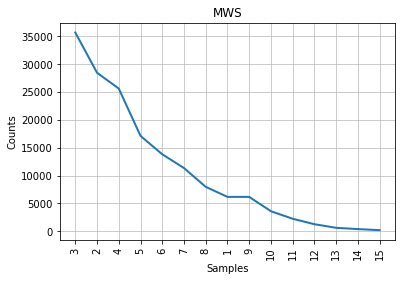

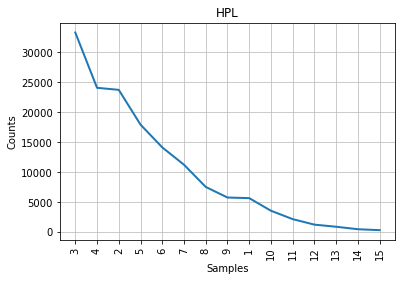

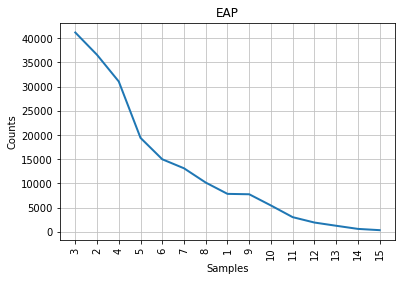

In [3]:
stories_by_author_tokens={}
stories_by_author_length_distributions = {}
for author in authors:
    tokens = nltk.word_tokenize(dictionaryauthors[author])

    # Filter out punctuation
    stories_by_author_tokens[author] = ([token for token in tokens
                                            if any(c.isalpha() for c in token)])

    # Get a distribution of token lengths
    token_lengths = [len(token) for token in stories_by_author_tokens[author]]
    stories_by_author_length_distributions[author] = nltk.FreqDist(token_lengths)
    stories_by_author_length_distributions[author].plot(15,title=author)

We can see that HP Lovecraft uses significantly more 4 letter words than 2 letter words like the others and similarly more 9 letter words than 1 letter words. 

We can see that the characteristic curves are slightly different for each of the authors. Next, we can try and use some more definitive methods to try and classify the texts.

Use the TfidfVectorizer which takes the raw text,does a little preprocessing, coverts them into tokens, and gets a vector of term frequencies. It then computes the idf weights for each token and multiplies this with the term frequency in each observation in the corpus and produces a tfidf matrix. This tfidf vector is then split into train and test sets so we can measure the performance of our models.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(traindf['text'])
print(vectors.shape)
X_train, X_test, y_train, y_test = train_test_split(vectors, authorsdupl, test_size=0.2, random_state=1337)


(19579, 25068)


We now train an SVM classifier with the training set

In [5]:
%%time
svm = LinearSVC()
svm.fit(X_train, y_train)

CPU times: user 342 ms, sys: 2.93 ms, total: 345 ms
Wall time: 343 ms


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Next, we use the trained SVM classifier to predict the labels for our test set

In [6]:
predictions = svm.predict(X_test)
print(list(predictions[0:10]))
print(y_test[:10])

['EAP', 'MWS', 'MWS', 'MWS', 'EAP', 'MWS', 'HPL', 'EAP', 'HPL', 'MWS']
['EAP', 'MWS', 'MWS', 'HPL', 'EAP', 'MWS', 'HPL', 'MWS', 'HPL', 'EAP']


This function is used to calculate what percentage of errors each author's wrong classifications make.

In [11]:
def find_authorwise_acc(predictions,y_test,authors):
    total_errors=0
    authorwise_acc={}
    for author in authors:
        authorwise_acc[author]=0
    for i in range(len(predictions)):
        if(predictions[i]!=y_test[i]):
            total_errors+=1
            authorwise_acc[y_test[i]]+=1
    for author in authors:
        authorwise_acc[author]/=total_errors

    print(authorwise_acc)





We can see that SVMs had 83 percent accuracy, with all authors having around the same percentage of wrong classifications made. The model seems to be unbiased in its classification.

In [12]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, predictions))
find_authorwise_acc(predictions,y_test,authors)

0.8327374872318692
{'MWS': 0.3450381679389313, 'HPL': 0.3251908396946565, 'EAP': 0.3297709923664122}


We use the same train set and use it to train a multinomial naive bayes classifier. 

In [9]:
from sklearn.naive_bayes import MultinomialNB
clf=MultinomialNB().fit(X_train,y_train)

We see that the accuracy of the naive bayes classifier is slightly lower. And the authorwise errors are not proportional. Half of the total errors are due to misclassifications of texts by HP Lovecraft. The misclassifications of Edgar Allan Poe texts are pretty low.

In [13]:
predicted_nb=clf.predict(X_test)
print(accuracy_score(y_test, predicted_nb))
find_authorwise_acc(predicted_nb,y_test,authors)

0.8074565883554647
{'MWS': 0.32625994694960214, 'HPL': 0.519893899204244, 'EAP': 0.15384615384615385}


It appears that with the same tf-idf matrix, SVMs seem to perform better than Naive Bayes classifiers. This could be because Naive Bayes looks at each token independently and models their probability on the word counts. SVM however produces a geometrical analysis, where it can model the interactions between several points as well. 